This notebooks is for testing if the workflows by Marine and Yiyu work on station J57A
Marine's notebook: https://github.com/Denolle-Lab/surface_events/blob/marine_cleanup_branch/src/SU_seismic_infrasound_MtRainier.ipynb
Yiyu's notebook: https://github.com/congcy/ELEP/blob/main/docs/tutorials/example_BB_continuous_data_PB_B204.ipynb

In [3]:
from seisbench.models import EQTransformer

import matplotlib.pyplot as plt
from datetime import datetime
from pnwstore.mseed import WaveformClient
import torch
import obspy
from obspy.core.utcdatetime import UTCDateTime
# import sys
# sys.path.append('/data/wsd01/pnwstore/')
import matplotlib.pyplot as plt
# from matplotlib.pyplot import Figure
import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client
import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from geopy import distance
from datetime import datetime
import rasterio as rio
import torch
plt.rcParams.update({'font.size': 10})
from utils import *
from tqdm import tqdm
import time 
import gc
from collections import Counter

import seisbench.models as sbm
device = torch.device("cpu")

from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from mbf_elep_func import apply_mbf
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func
from ELEP.elep.trigger_func import picks_summary_simple

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

In [5]:
client = WaveformClient()
model = EQTransformer.from_pretrained('original')
model.to(torch.device('cuda'));

## Test Station J57A


In [6]:
s_J57A = client.get_waveforms(network="7D", station="J57A", channel="?H?", year=2012, month=7, day=2)
s_J57A.filter(type='bandpass',freqmin=4,freqmax=15)
s_J57A

3 Trace(s) in Stream:
7D.J57A..BH1 | 2012-07-02T00:00:00.013900Z - 2012-07-02T23:59:59.993900Z | 50.0 Hz, 4320000 samples
7D.J57A..BH2 | 2012-07-02T00:00:00.013900Z - 2012-07-02T23:59:59.993900Z | 50.0 Hz, 4320000 samples
7D.J57A..BHZ | 2012-07-02T00:00:00.013900Z - 2012-07-02T23:59:59.993900Z | 50.0 Hz, 4320000 samples

## Applying the EQTransformer


In [7]:
all_picks, all_detections = model.classify(s_J57A)

/home/hbito/.local/lib/python3.8/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


In [8]:
Counter([p.phase for p in all_picks])

Counter({'P': 3, 'S': 2})

In [9]:
for p in all_detections:
    print(p)

7D.J57A.	2012-07-02T01:51:48.373900Z	2012-07-02T01:51:51.533900Z
7D.J57A.	2012-07-02T17:28:22.313900Z	2012-07-02T17:28:25.363900Z


In [11]:
index = 0 # you can change this accordingly 
pick = all_picks[index]

print(f"This {pick.phase} phase is picked at {pick.peak_time}")

This P phase is picked at 2012-07-02T01:51:48.533900Z


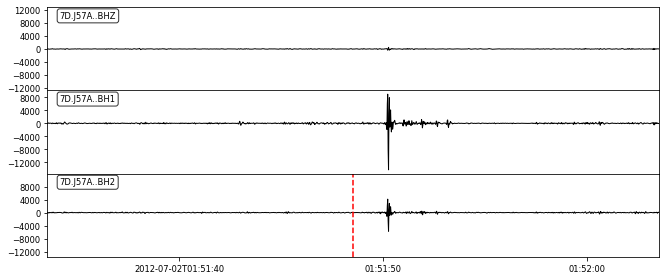

In [60]:
trim_s_J57A = s_J57A.copy().trim(starttime = UTCDateTime(pick.peak_time) - 15, 
                endtime = UTCDateTime(pick.peak_time) + 15)
fig =plt.figure(figsize = (10, 4))
trim_s_J57A.plot(fig=fig)
# if pick.phase == P:
plt.axvline(pick.peak_time, linestyle = '--', color = 'r', label = f'{pick.phase} pick')

## Try ELEP
Referencing Marine and Yiyu's notebook (Ensemble phase picking (continuous waveform, broadband): https://github.com/Denolle-Lab/surface_events/blob/marine_cleanup_branch/src/SU_seismic_infrasound_MtRainier.ipynb and https://github.com/congcy/ELEP/blob/main/docs/tutorials/example_BB_continuous_data_PB_B204.ipynb.

In [31]:
# download models
pretrain_list = ["pnw","ethz","instance","scedc","stead","geofon"]
pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
# pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

In [32]:
pn_pnw_model.to(device);
pn_ethz_model.to(device);
pn_scedc_model.to(device);
# pn_neic_model.to(device);
pn_geofon_model.to(device);
pn_stead_model.to(device);
pn_instance_model.to(device);

In [33]:
thr = 5 #SNR threshold
low_cut = 1 #low frequency threshold
high_cut = 12 #high frequency threshold
fs = s_J57A[0].stats.sampling_rate
fqmin = low_cut
fqmax = high_cut
dt = 1/fs
nfqs = 10
nt = 6000; nc = 3
fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

In [34]:
sdata = np.array(s_J57A)

twin = 6000     # length of time window
step = 3000     # step length
npts = sdata.shape[1]
l_blnd, r_blnd = 500, 500
nseg = int(np.ceil((npts - twin) / step)) + 1
windows = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
tap = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, 6)))


windows_std = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
windows_max = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
windows = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
windows_idx = np.zeros(nseg, dtype=np.int32)

for iseg in range(nseg):
    idx = iseg * step
    windows[iseg, :] = sdata[:, idx:idx + twin]
    windows[iseg, :] -= np.mean(windows[iseg, :], axis=-1, keepdims=True)
    # original use std norm
    windows_std[iseg, :] = windows[iseg, :] / np.std(windows[iseg, :]) + 1e-10
    # others use max norm
    windows_max[iseg, :] = windows[iseg, :] / (np.max(np.abs(windows[iseg, :]), axis=-1, keepdims=True))
    windows_idx[iseg] = idx

# taper
windows_std[:, :, :6] *= tap; windows_std[:, :, -6:] *= tap[::-1]; 
windows_max[:, :, :6] *= tap; windows_max[:, :, -6:] *= tap[::-1];
del windows

### 3.2 EqT batch picking using 6 pre-trained model
Then we use EqTransformer model to perform prediction on each of the time window. We use six different pre-trained model, listed in `pretrain_list`. We loop over these pretrain weights, and save the results in `batch_pred` variable of shape [2, 6, 479, 6000]. Understanding the shape of this varibale is important:
- 2: one for P-wave and another for S-wave. We don't save detection branch.
- 6: six pretrained weights
- 479: the number of time windows
- 6000: the number of points in each time window (60 sec@100 Hz)

In [35]:
pretrain_list = ['original', 'ethz', 'instance', 'scedc', 'stead']

# dim 0: 0 = P, 1 = S
batch_pred = np.zeros([2, len(pretrain_list), nseg, twin], dtype = np.float32) 

for ipre, pretrain in enumerate(pretrain_list):
    t0 = time.time()
    eqt = sbm.EQTransformer.from_pretrained(pretrain)
    eqt.to(device);
    eqt._annotate_args['overlap'] = ('Overlap between prediction windows in samples \
                                    (only for window prediction models)', step)
    eqt._annotate_args['blinding'] = ('Number of prediction samples to discard on \
                                     each side of each window prediction', (l_blnd, r_blnd))
    eqt.eval();
    if pretrain == 'original':
        # batch prediction through torch model
        windows_std_tt = torch.Tensor(windows_std)
        _torch_pred = eqt(windows_std_tt.to(device))
    else:
        windows_max_tt = torch.Tensor(windows_max)
        _torch_pred = eqt(windows_max_tt.to(device))
    batch_pred[0, ipre, :] = _torch_pred[1].detach().cpu().numpy()
    batch_pred[1, ipre, :] = _torch_pred[2].detach().cpu().numpy()
    
    t1 = time.time()
    print(f"picking using [{pretrain}] model: %.3f second" % (t1 - t0))
    
# clean up memory
del _torch_pred, windows_max_tt, windows_std_tt
del windows_std, windows_max
gc.collect()
torch.cuda.empty_cache()

print(f"All prediction shape: {batch_pred.shape}")

picking using [original] model: 1.548 second
picking using [ethz] model: 0.985 second
picking using [instance] model: 0.980 second
picking using [scedc] model: 1.155 second
picking using [stead] model: 0.934 second
All prediction shape: (2, 5, 1439, 6000)


### 3.3 stacking (concateneate window back to day-long stream)
This section we merge all time windows into the continuous prediction. We use the `stacking` function: it takes matrix of shape [nseg, ntrace] and merge it into an 1D array.

In [36]:
def stacking(data, npts, l_blnd, r_blnd):
    _data = data.copy()
    stack = np.full(npts, np.nan, dtype = np.float32)
    _data[:, :l_blnd] = np.nan; _data[:, -r_blnd:] = np.nan
    stack[:twin] = _data[0, :]
    for iseg in range(nseg-1):
        idx = step*(iseg+1)
        stack[idx:idx + twin] = \
                np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)
    return stack

In [37]:
pretrain_pred = np.zeros([2, len(pretrain_list), npts], dtype = np.float32)
for ipre, pretrain in enumerate(pretrain_list):
    # 0 for P-wave
    pretrain_pred[0, ipre, :] = stacking(batch_pred[0, ipre, :], npts, l_blnd, r_blnd)
    
    # 1 for S-wave
    pretrain_pred[1, ipre, :] = stacking(batch_pred[1, ipre, :], npts, l_blnd, r_blnd)

/tmp/ipykernel_909223/1491012717.py:9: RuntimeWarning: All-NaN axis encountered
  np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)


Text(0.5, 0, 'Time')

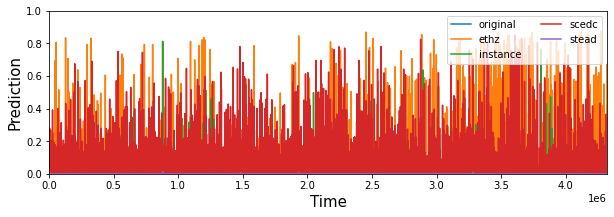

In [38]:
plt.figure(figsize = (10, 3))
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[0, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')
plt.xlabel("Time", fontsize = 15)

## 4 ensemble calculation


In [39]:
paras_maximum = {'dt':1/fs, 'win':1, 'window_flag':False, 'method':'max'}
paras_semblance = {'dt':1/fs, 'semblance_order':2, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.05, 0.05

max_pred = np.zeros([2, nseg, twin], dtype = np.float32)
smb_pred = np.zeros([2, nseg, twin], dtype = np.float32)

In [40]:
# calculate the ensemble maximum and semblance
## the semblance may takes a while bit to calculate
for iseg in tqdm(range(nseg)):
    # 0 for P-wave
    max_pred[0, iseg, :] = ensemble_statistics(batch_pred[0, :, iseg, :], paras_maximum)
    smb_pred[0, iseg, :] = ensemble_semblance(batch_pred[0, :, iseg, :], paras_semblance)
    
    # 1 for P-wave
    max_pred[1, iseg, :] = ensemble_statistics(batch_pred[1, :, iseg, :], paras_maximum)
    smb_pred[1, iseg, :] = ensemble_semblance(batch_pred[1, :, iseg, :], paras_semblance)

## ... and stack
# 0 for P-wave
max_p = stacking(max_pred[0, :], npts, l_blnd, r_blnd)
smb_p = stacking(smb_pred[0, :], npts, l_blnd, r_blnd)

# 1 for P-wave
max_s = stacking(max_pred[1, :], npts, l_blnd, r_blnd)
smb_s = stacking(smb_pred[1, :], npts, l_blnd, r_blnd)

# clean-up RAM
del max_pred, smb_pred, batch_pred

100%|██████████| 1439/1439 [01:20<00:00, 17.86it/s]
/tmp/ipykernel_909223/1491012717.py:9: RuntimeWarning: All-NaN axis encountered
  np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)


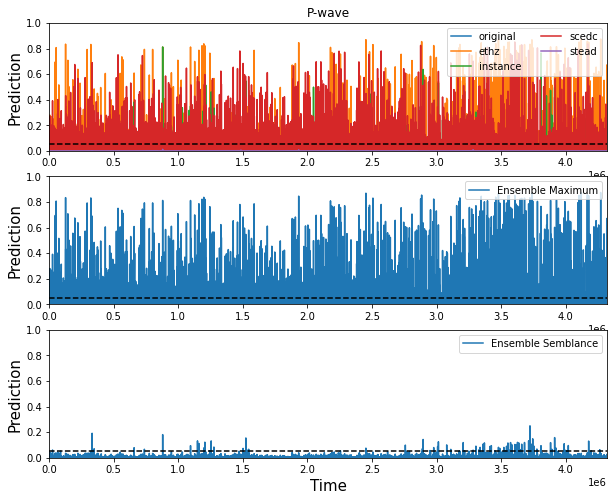

In [41]:
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title("P-wave")
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[0, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(p_thrd, 0, npts, linestyle = '--', color = 'k')
plt.legend(ncols = 2, loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(max_p, label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(p_thrd, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.plot(smb_p, label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(p_thrd, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

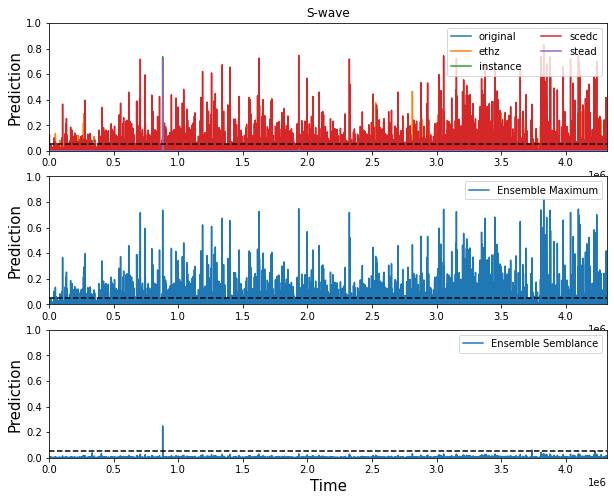

In [42]:
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title("S-wave")
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[1, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')
plt.hlines(s_thrd, 0, npts, linestyle = '--', color = 'k')

plt.subplot(3, 1, 2)
plt.plot(max_s, label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(s_thrd, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')


plt.subplot(3, 1, 3)
plt.plot(smb_s, label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(s_thrd, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

## Picking and catalog

In [43]:
p_index = picks_summary_simple(smb_p, p_thrd)
s_index = picks_summary_simple(smb_s, s_thrd)
print(f"{len(p_index)} P picks\n{len(s_index)} S picks")

82 P picks
3 S picks


In [44]:
# Define the start time and delta that are needed in the next cell
delta = s_J57A[0].stats.delta
starttime = s_J57A[0].stats.starttime

/tmp/ipykernel_909223/2584090198.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (10, 2))


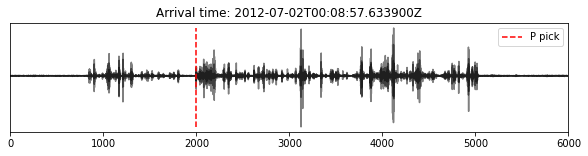

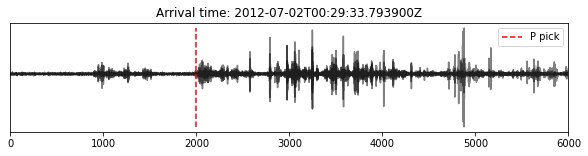

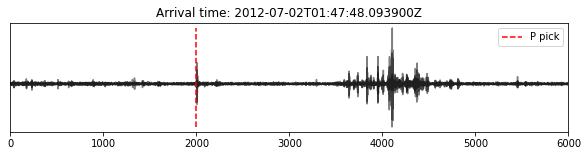

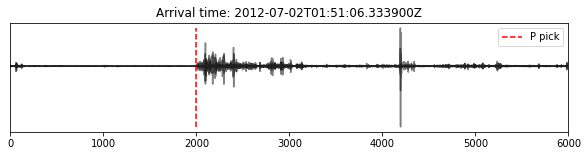

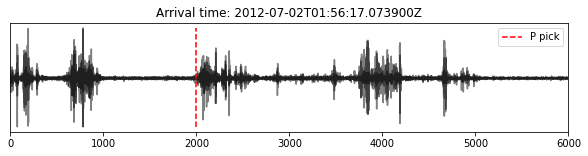

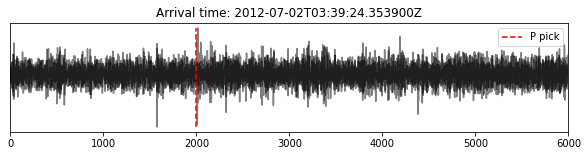

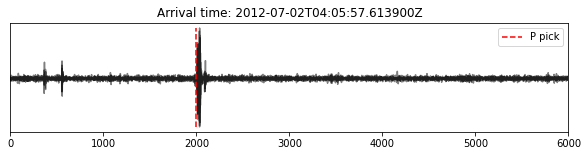

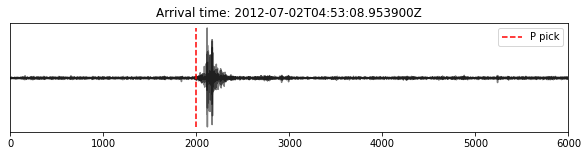

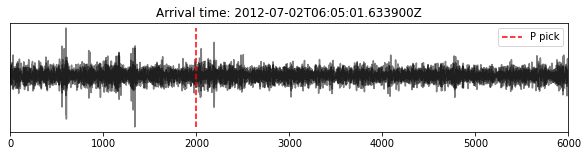

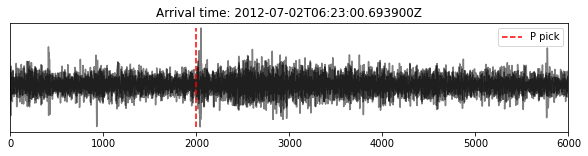

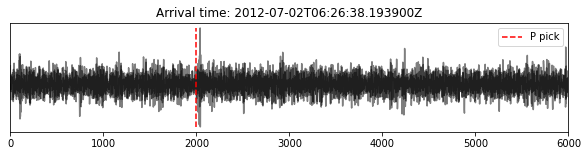

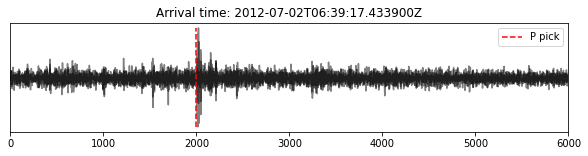

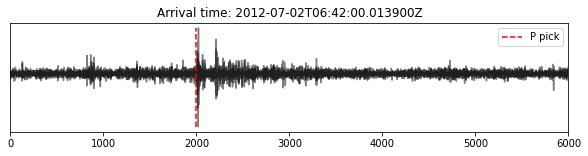

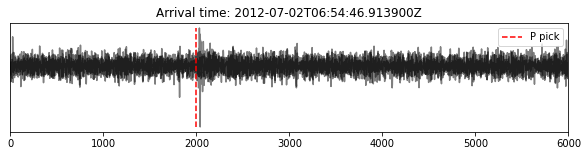

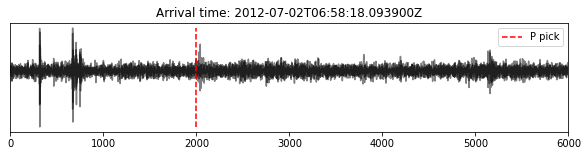

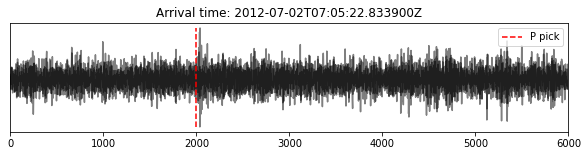

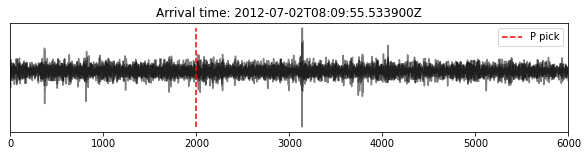

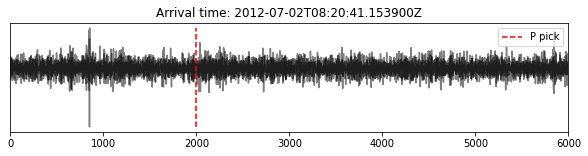

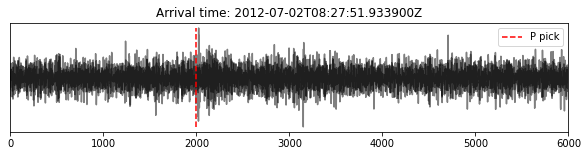

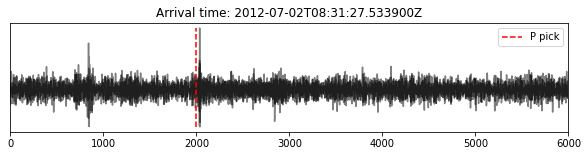

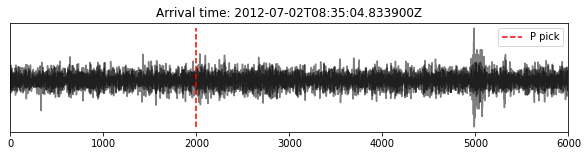

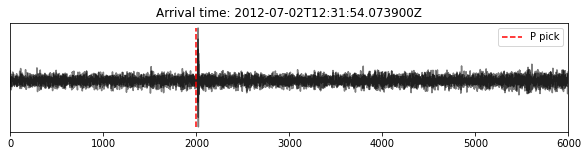

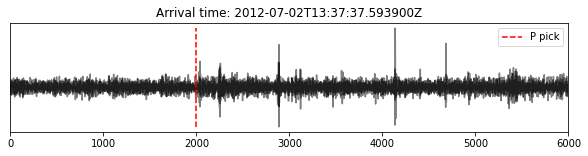

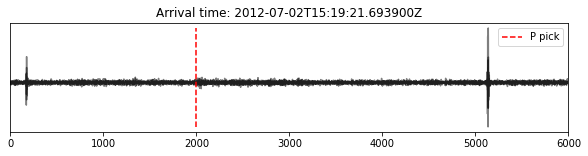

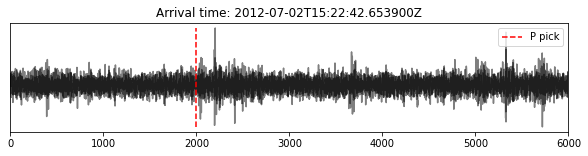

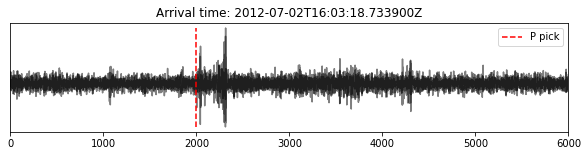

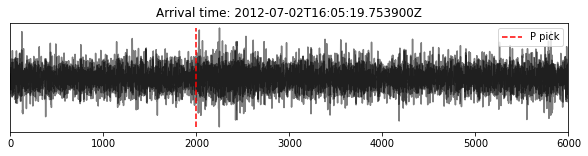

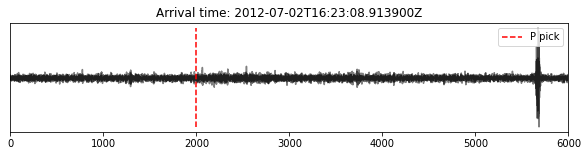

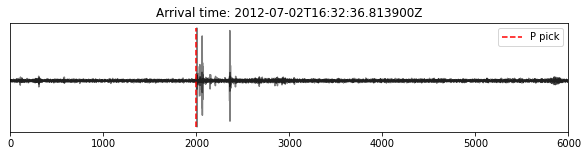

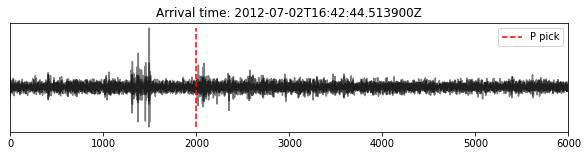

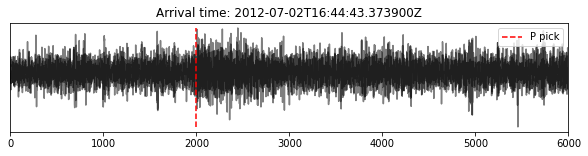

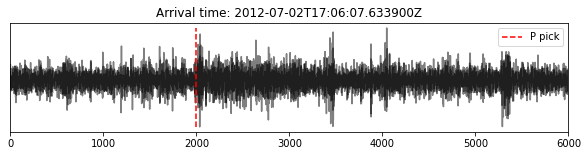

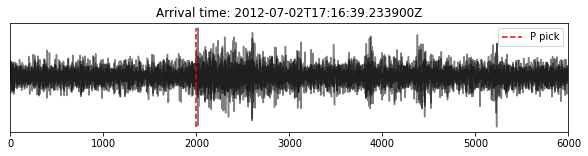

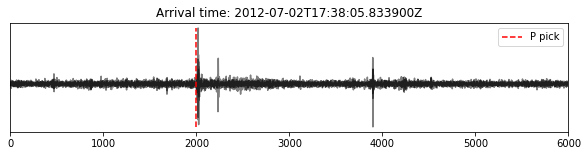

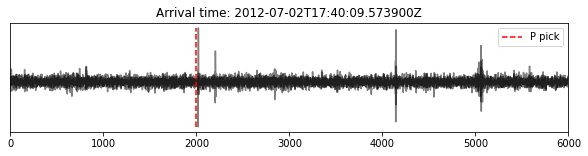

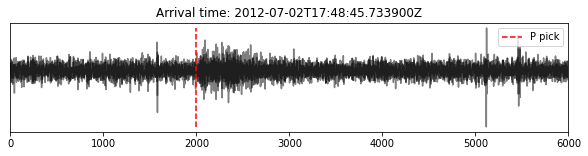

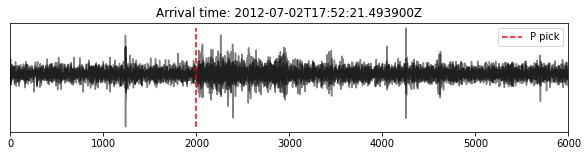

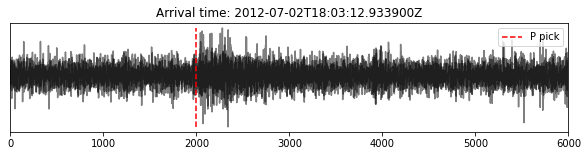

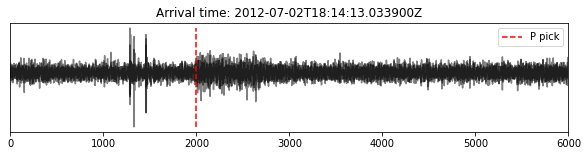

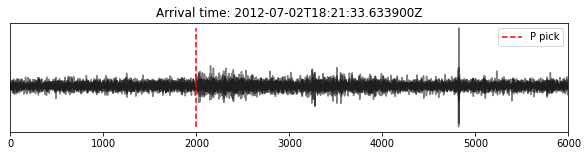

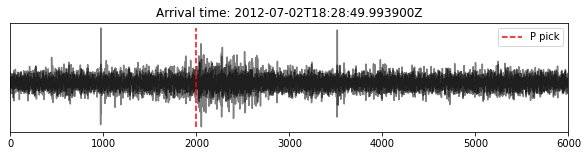

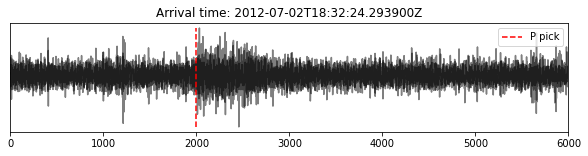

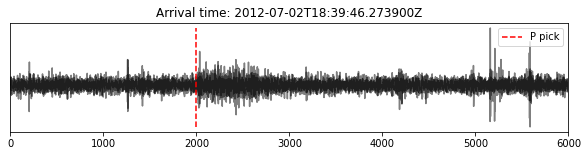

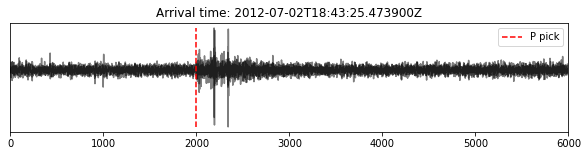

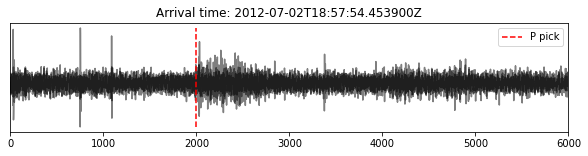

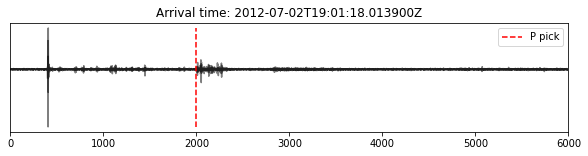

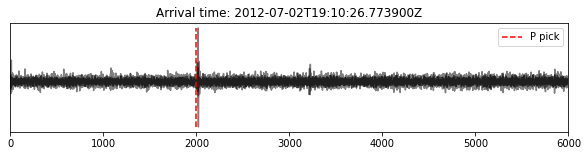

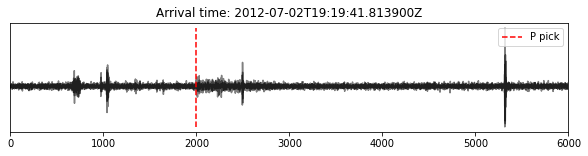

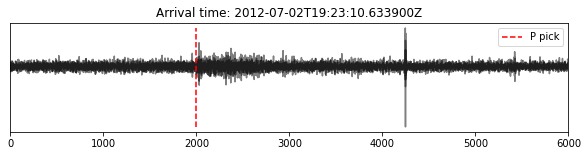

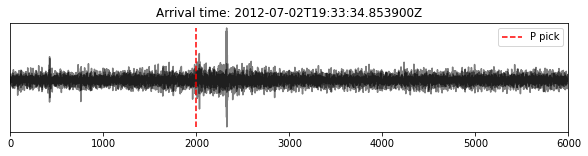

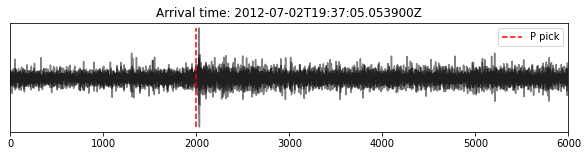

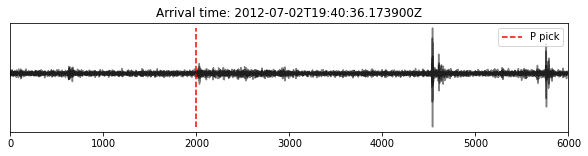

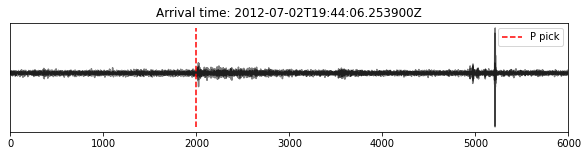

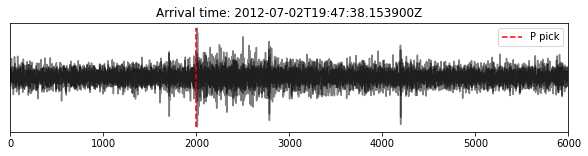

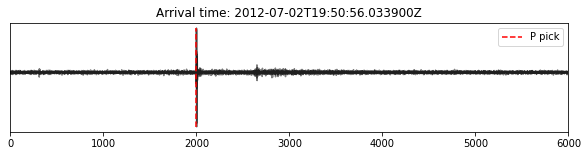

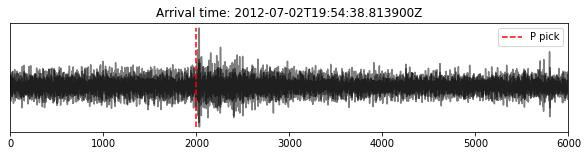

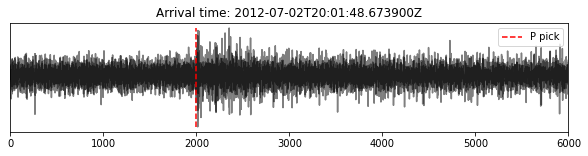

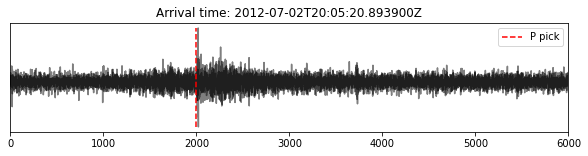

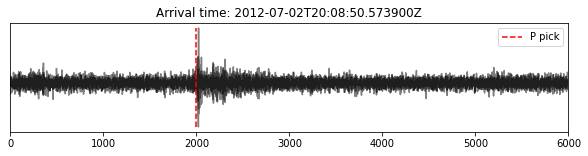

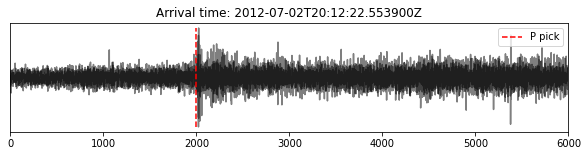

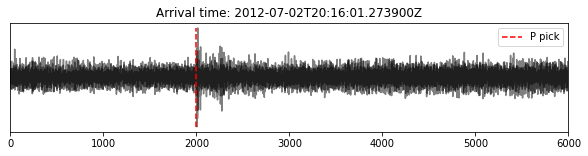

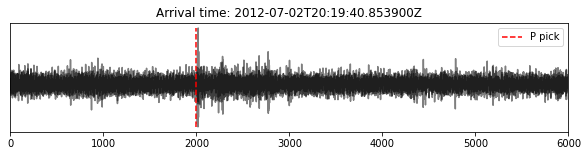

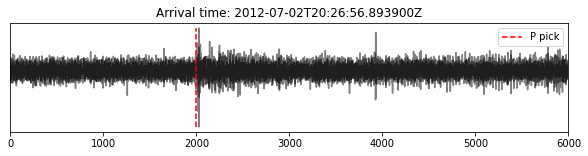

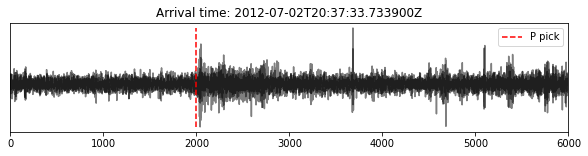

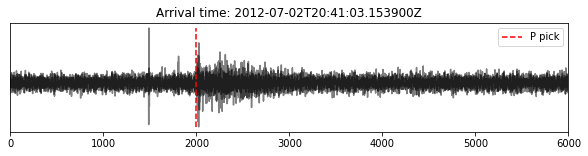

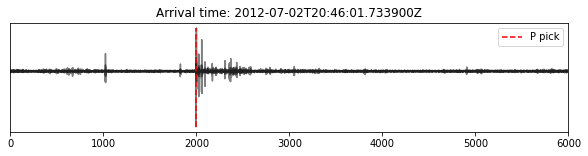

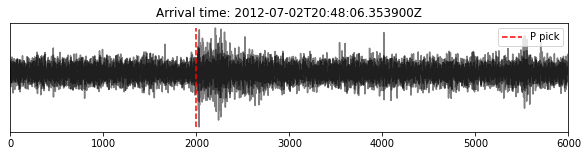

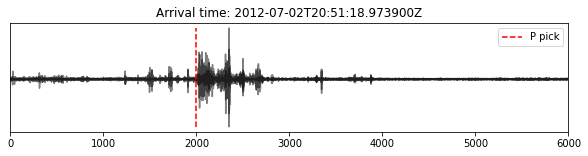

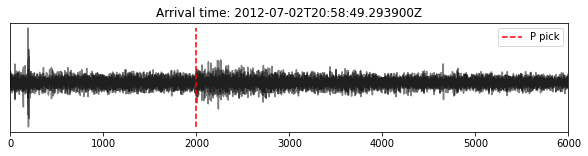

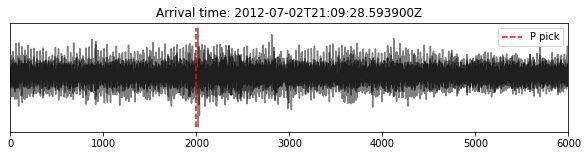

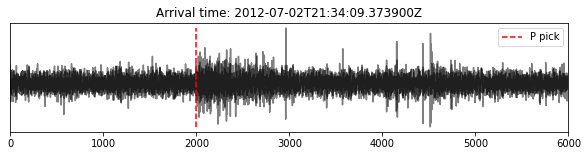

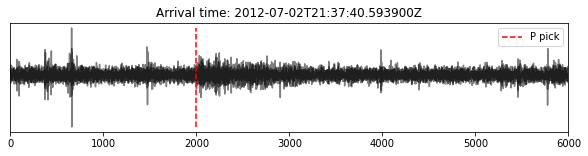

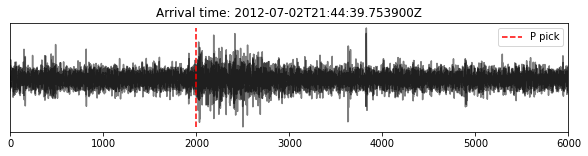

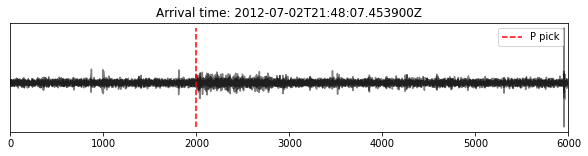

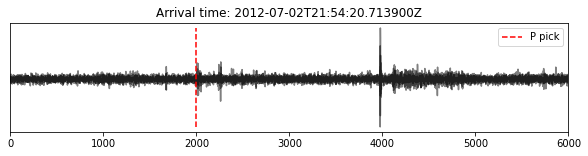

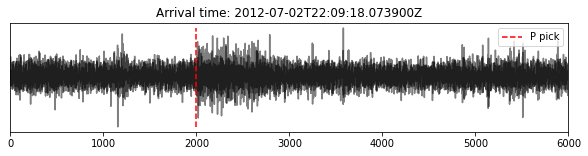

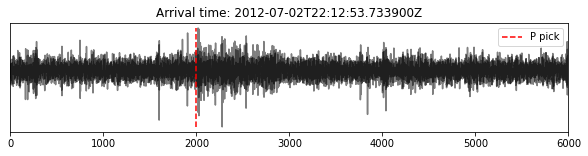

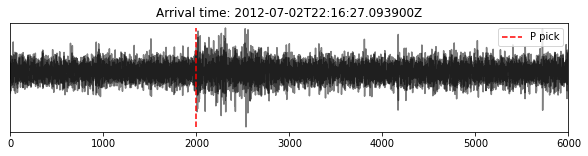

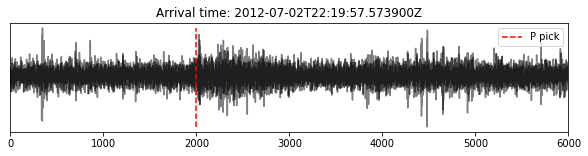

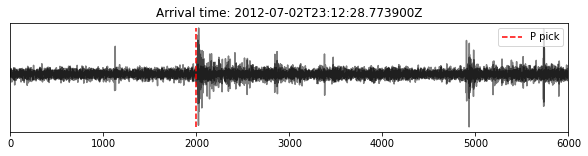

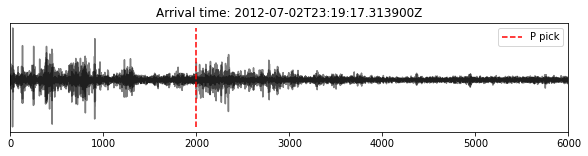

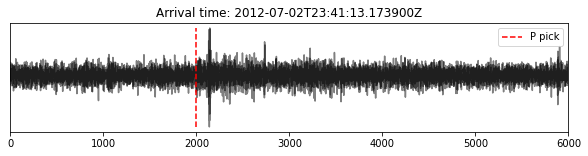

In [45]:
## all picks for this station and this day by PNSN
catalog = pd.read_csv("https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/PB.B204.2022.037.csv")
catalog = catalog[catalog['phase'] == 'P']

## gray waveform: there is a pick by PNSN within 1 second
## black waveform: probably a new event detected
for idx in p_index:
    arrival_utc = starttime + idx * delta
    plt.figure(figsize = (10, 2))
    w = sdata[:, idx-2000:idx+4000]
    nearby_pick = abs(arrival_utc.timestamp - catalog['timestamp']) < 1
    if nearby_pick.any():
        dt = np.abs(catalog.loc[nearby_pick]['timestamp'] - arrival_utc.timestamp)
        plt.plot(w.T, color = 'gray', alpha = 0.5)
        plt.vlines(2000, w.min(), w.max(), linestyle = '--', color = 'r', 
                   label=f'P pick \n$\\Delta t = $%.3f sec' % dt.values[0])
    else:
        plt.plot(w.T, color = 'black', alpha = 0.5)
        plt.vlines(2000, w.min(), w.max(), linestyle = '--', color = 'r', label = 'P pick')
    plt.title(f"Arrival time: {arrival_utc}")
    plt.yticks([]); plt.legend(loc = 'upper right')
    plt.xlim([0, 6000])

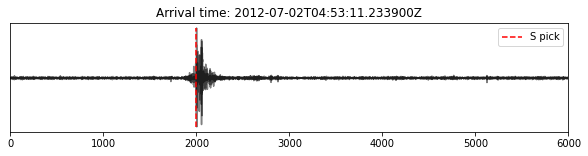

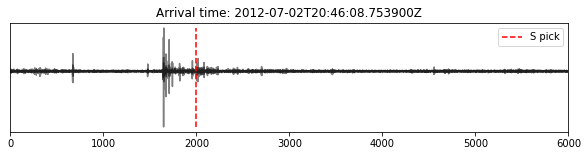

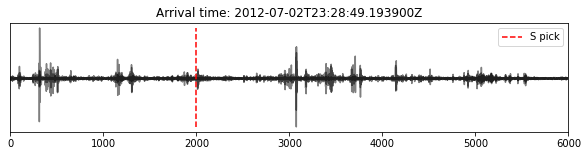

In [30]:
## all picks for this station and this day by PNSN
catalog = pd.read_csv("https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/PB.B204.2022.037.csv")
catalog = catalog[catalog['phase'] == 'S']

## gray waveform: there is a pick by PNSN within 1 second
## black waveform: probably a new event detected
for idx in s_index:
    arrival_utc = starttime + idx * delta
    plt.figure(figsize = (10, 2))
    w = sdata[:, idx-2000:idx+4000]
    nearby_pick = abs(arrival_utc.timestamp - catalog['timestamp']) < 1
    if nearby_pick.any():
        dt = np.abs(catalog.loc[nearby_pick]['timestamp'] - arrival_utc.timestamp)
        plt.plot(w.T, color = 'gray', alpha = 0.5)
        plt.vlines(2000, w.min(), w.max(), linestyle = '--', color = 'r', 
                   label=f'S pick \n$\\Delta t = $%.3f sec' % dt.values[0])
    else:
        plt.plot(w.T, color = 'black', alpha = 0.5)
        plt.vlines(2000, w.min(), w.max(), linestyle = '--', color = 'r', label = 'S pick')
    plt.title(f"Arrival time: {arrival_utc}")
    plt.yticks([]); plt.legend(loc = 'upper right')
    plt.xlim([0, 6000])